In [4]:
import tsfresh as tsf
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import mord
import joblib
import dill
import imblearn

from importlib import reload
from itertools import product
from scipy import signal, stats
from tqdm.auto import tqdm
from sklearn import preprocessing, neighbors, linear_model, ensemble, decomposition, compose
from sklearn import feature_selection, model_selection, metrics, dummy, pipeline, svm, neural_network
from dask_ml.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
from src import main, feature_model

In [42]:
dataset = 'real_phone_accel-tsfeatures'
features_df = pd.read_csv(f'extracted_features/{dataset}.csv')

label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
labels = pd.concat([
    pd.read_csv('/home/hy180/projects/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv', index_col=0),
    pd.read_csv('/home/hy180/projects/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv', index_col=0),
], axis=0)

# These features don't compute for a number of observations
drop_cols = ['rms__friedrich_coefficients__m_3__r_30__coeff_0',
       'rms__friedrich_coefficients__m_3__r_30__coeff_1',
       'rms__friedrich_coefficients__m_3__r_30__coeff_2',
       'rms__friedrich_coefficients__m_3__r_30__coeff_3',
       'rms__max_langevin_fixed_point__m_3__r_30']
# These fft features are null for our size of windows
null_fft_cols = ['rms__fft_coefficient__coeff_%d__attr_"%s"' % (n, s) 
                     for n, s in product(range(51, 100), ['abs', 'angle', 'imag', 'real'])]
# Sample entropy can take inf which screws with models
inf_cols = ['rms__sample_entropy']
df = features_df.drop(columns=[*drop_cols, *null_fft_cols, *inf_cols]).dropna().merge(labels, right_on='measurement_id', left_on='samp_id')
print('%d rows dropped due to nans in features' % (features_df.shape[0] - df.shape[0]))

# Looking at feature scales

0 rows dropped due to nans in features


# Model

In [6]:
from dask_jobqueue import SLURMCluster
from distributed import Client, LocalCluster

In [7]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', cores=2, memory='2gb', walltime='1:00:00', death_timeout=60)
    client = Client(cluster)
    cluster.adapt(minimum=1, maximum=100)

In [8]:
# Local cluster for debugging
try:
    local_cluster.close()
    local_client.close()
except NameError:
    pass
finally:
    local_cluster = LocalCluster(n_workers=4, threads_per_worker=1, dashboard_address='0.0.0.0:8786')
    local_client = Client(local_cluster)
    local_cluster.adapt(minimum=0, maximum=4)

In [26]:
scaler = preprocessing.RobustScaler(quantile_range=(1, 99))
scaler_pg = {'scaler__quantile_range': [(.1, 99.9), (.5, 99.5), (1, 99), (5, 95), (10, 90)],}
# scaler = preprocessing.MinMaxScaler()

# Keep features w/ variance in top 95%ile 
var = lambda X, y: np.var(X, axis=0)
f_select = feature_selection.SelectPercentile(var, percentile=95)
# f_select_pg = {'f_select__percentile': [95, 80, 50, 25, 10],}
f_select_pg = {'f_select__percentile': stats.uniform(0, 100)}
# f_select = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=30)

# model = linear_model.Ridge()
# model_pg = {'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = svm.SVR()
# model_pg = {'model__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'model__regressor__C': stats.chi2(df=2)}
# model = linear_model.ElasticNet()
# model_pg = {'model__regressor__l1_ratio': stats.uniform(0, 1), 'model__regressor__alpha': stats.chi2(df=2), }
# model_pg = {'model__regressor__l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.99], 'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = mord.OrdinalRidge()
# model_pg = {'model__regressor__alpha': stats.chi2(df=2), }
model = ensemble.RandomForestRegressor()
model_pg = {'model__regressor__n_estimators': stats.randint(50, 100), 'model__regressor__max_depth': stats.randint(10, 25), 'model__regressor__max_features': [.25, 'auto']}
# model = neural_network.MLPRegressor(learning_rate='adaptive')
# model_pg = {'model__regressor__hidden_layer_sizes': [(100), (50, 50)]}

clip_out = preprocessing.FunctionTransformer(np.clip, kw_args={'a_min': 0, 'a_max': 4})
clipped_model = compose.TransformedTargetRegressor(regressor=model, inverse_func=clip_out.transform)

pipe = pipeline.Pipeline([
    ('scaler', scaler), 
    ('f_select', f_select), 
    ('model', clipped_model),
], verbose=1)

param_grid = {
    **scaler_pg,
    **f_select_pg,
    **model_pg,
}

metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

cv = model_selection.StratifiedKFold(shuffle=True)
search = RandomizedSearchCV(pipe, param_grid, n_iter=100, scoring=metric, cv=cv, scheduler=client)

In [71]:
label = 'dyskinesia'

id_cols = ['samp_id']
labeled_samps = df.dropna(subset=[label])

y = df.loc[labeled_samps.index, label].astype('int')
X = labeled_samps.drop(columns=[*label_cols, *id_cols])

In [32]:
cv_fit = search.fit(X, y)
cv_results = pd.DataFrame(cv_fit.cv_results_)

In [29]:
resultset_name = f'{dataset}_{type(model).__name__}_{label}'
cv_results.to_csv(f'performance/cv_paramsweeps/{resultset_name}.csv')
win_params = cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0]
winner = pipe.set_params(**win_params)
with open(f'models/paramsweep_winners/{resultset_name}.model', 'wb') as f:
    dill.dump(winner, f)

In [17]:
sns.relplot(data=cv_results, x='param_model__regressor__alpha', y='rank_test_score')

ValueError: Could not interpret input 'param_model__regressor__alpha'

In [30]:
cv_results.sort_values(by='rank_test_score')

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_f_select__percentile,param_model__regressor__max_depth,param_model__regressor__max_features,param_model__regressor__n_estimators,param_scaler__quantile_range
26,"{'f_select__percentile': 66.20188696796976, 'm...",0.521923,0.043467,0.021482,0.009717,-0.162472,-0.279783,-0.171122,-0.245534,-0.187867,-0.209459,0.045671,1,66.2019,10,0.25,83,"(5, 95)"
15,"{'f_select__percentile': 74.31767807904166, 'm...",0.461846,0.033035,0.018145,0.009711,-0.187027,-0.308398,-0.152474,-0.236841,-0.173000,-0.211732,0.055920,2,74.3177,22,0.25,61,"(10, 90)"
99,"{'f_select__percentile': 97.84987138443901, 'm...",0.635179,0.071751,0.012723,0.003337,-0.180972,-0.280579,-0.162336,-0.241539,-0.192980,-0.211771,0.043365,3,97.8499,16,0.25,74,"(0.1, 99.9)"
21,"{'f_select__percentile': 42.64694383823446, 'm...",0.842002,0.069792,0.016464,0.006770,-0.163445,-0.272981,-0.173038,-0.286579,-0.162473,-0.211939,0.055902,4,42.6469,20,auto,71,"(5, 95)"
72,"{'f_select__percentile': 93.61446061014533, 'm...",0.853162,0.260817,0.013685,0.005566,-0.167460,-0.289591,-0.170155,-0.229952,-0.203677,-0.212208,0.045152,5,93.6145,11,0.25,65,"(1, 99)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"{'f_select__percentile': 9.745060074100964, 'm...",0.319921,0.042231,0.016622,0.005971,-0.208968,-0.307249,-0.188254,-0.305278,-0.253157,-0.252578,0.048708,96,9.74506,14,0.25,60,"(0.1, 99.9)"
51,"{'f_select__percentile': 9.074881730070917, 'm...",0.210209,0.016647,0.054492,0.052732,-0.256540,-0.274553,-0.251951,-0.286261,-0.204465,-0.254995,0.027867,97,9.07488,12,0.25,54,"(10, 90)"
84,"{'f_select__percentile': 5.492719149952318, 'm...",0.364173,0.030086,0.021977,0.017679,-0.252815,-0.306169,-0.280640,-0.250494,-0.219792,-0.262184,0.029238,98,5.49272,22,auto,89,"(10, 90)"
52,"{'f_select__percentile': 3.8101892237327295, '...",0.235696,0.045127,0.010996,0.001014,-0.280717,-0.301122,-0.291844,-0.282777,-0.203899,-0.272398,0.034610,99,3.81019,22,0.25,61,"(10, 90)"


In [11]:
winner = cv_fit.best_estimator_

In [175]:
winner_fp = f'models/paramsweep_winners/{type(model).__name__}_{label}.model'
with open(winner_fp, 'wb') as f:
    dill.dump(winner, f)

## Single train-test split for evaluation

In [54]:
import ast

cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_{type(model).__name__}_{label}.csv')
win_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
winner = pipe.set_params(**win_params)

In [63]:
reload(main)

<module 'src.main' from '/home/hy180/projects/beat_pd/src/main.py'>

In [70]:
labels.loc[features_df.samp_id].dyskinesia.value_counts()

0.0    110
1.0     94
2.0      5
Name: dyskinesia, dtype: int64

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing f_select, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.3s


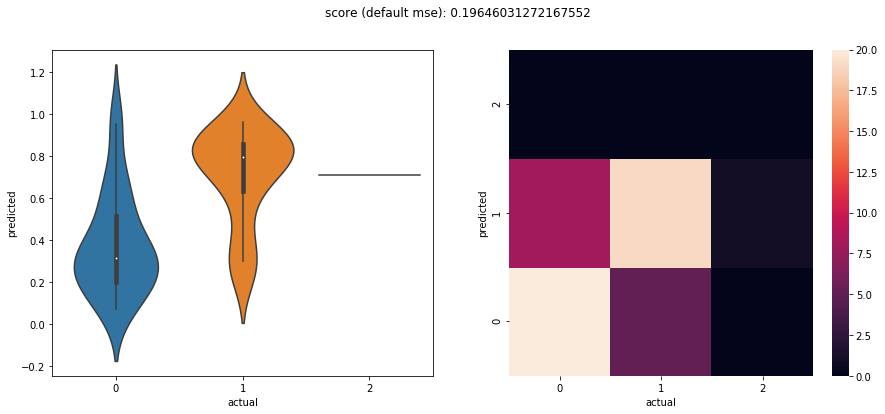

In [72]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.25, stratify=y)

with joblib.parallel_backend('loky'):
    winner.fit(x_train, y_train)
    pred = winner.predict(x_test)

main.plot_performance(y_test, pred)

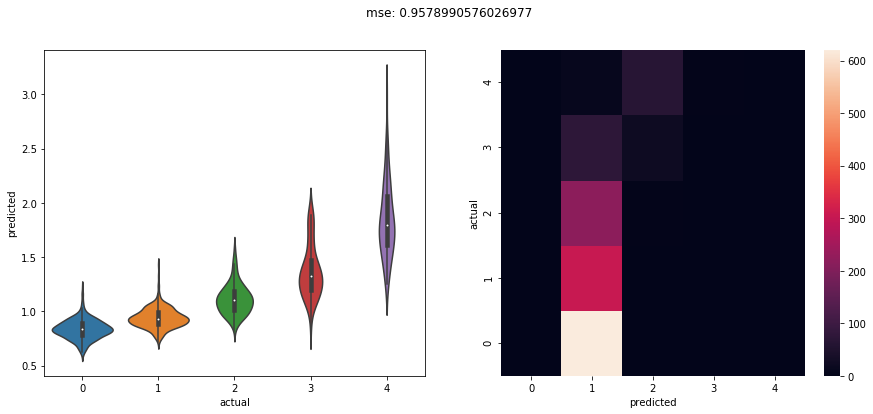

In [183]:
# training set recall
x_test, y_test = x_train, y_train
pred = winner.predict(x_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.violinplot(data=pd.DataFrame({'actual': y_test, 'predicted': pred}), x='actual', y='predicted', ax=ax1)

# confusion matrix
label_vals = np.sort(y_test.unique())
cm = metrics.confusion_matrix(y_test, np.round(pred), labels=label_vals)
sns.heatmap(cm, xticklabels=label_vals, yticklabels=label_vals, ax=ax2)
ax2.set_xlabel('predicted')
ax2.set_ylabel('actual')
ax2.invert_yaxis()

mse = metrics.mean_squared_error(y_test, pred)
_ = fig.suptitle(f'mse: {mse}')

# Baseline for reference

In [177]:
label = 'on_off'
features = df[df.index.isin(df.dropna(subset=[label]).index)].drop(columns=[*label_cols])

y = df.loc[features.index, label].astype('int')
X = features

Text(0.5, 1.0, 'mse of null model: -1.487504')

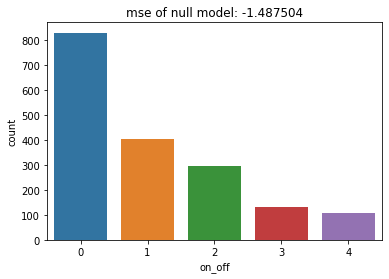

In [178]:
baseline_model = dummy.DummyRegressor(strategy='mean')
baseline_cv = model_selection.cross_validate(baseline_model, X, y, scoring=metric)
baseline_scores = baseline_cv['test_score']
ax = sns.countplot(y)
ax.set_title('mse of null model: %f' % baseline_scores.mean())

In [179]:
# patient-specific mean predictor
subj_means = labels.groupby('subject_id').mean()
X_subjs = labels.loc[X.index][['subject_id']]
naive_pred = X_subjs.join(subj_means, on='subject_id')[[label]].rename({label: 'prediction'}, axis=1)
metrics.mean_squared_error(y, naive_pred)

1.2344720544673466

# Predictions on test set

In [141]:
label = 'tremor'
with open(f'models/paramsweep_winners/RandomForestRegressor_{label}.model', 'rb') as f:
    winner = dill.load(f)

In [142]:
# TODO: only predict required measurements for each label
test_index = pd.read_csv(f'test_predictions/sub_template_{label}.csv', index_col=0).index
test_features_df = pd.concat([
    pd.read_csv('extracted_features/tsfeatures_cis_test.csv', index_col=0), 
    pd.read_csv('extracted_features/tsfeatures_real_test.csv', index_col=0)
]).drop(columns=drop_cols).reindex(test_index)

test_subjs = pd.concat([
    pd.read_csv('data/test_set/cis-pd/cis-pd.CIS-PD_Test_Data_IDs.csv', index_col=0), 
    pd.read_csv('data/test_set/real-pd/real-pd.REAL-PD_Test_Data_IDs.csv', index_col=0)
]).reindex(test_index)

In [143]:
# Predict patient-specific mean if data not available
nodata_obs = test_subjs.loc[test_features_df[test_features_df.isna().sum(axis=1) > 0].index]
nodata_predictions = nodata_obs.join(subj_means, on='subject_id')[[label]].rename({label: 'prediction'}, axis=1)

In [144]:
X = test_features_df.dropna(axis='index')

test_predictions = winner.predict(X)
test_predictions_df = pd.concat([
    pd.DataFrame(index=X.index, data={'prediction': test_predictions}),
    nodata_predictions,
], axis=0)

In [145]:
test_predictions_df.to_csv(f'test_predictions/test_predictions_{label}.csv', index=True)

# Dimensionality Reduction

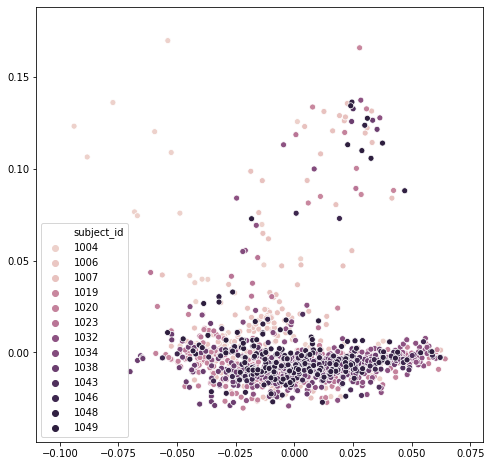

In [164]:
label = 'subject_id'

X = f_select.fit_transform(scaler.fit_transform(features), y=y)
pca = decomposition.FastICA(n_components=2)
proj = pca.fit_transform(X)
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=df.loc[features.index, label], legend='full')